In [1]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path
load_dotenv()
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
import pyrosm
import os
import geopandas as gpd
from wordcloud import WordCloud
from collections import Counter

### Cargar footways

In [2]:
output_file = "footways.pkl"
# Cargar el archivo existente
with open(output_file, "rb") as file:
    footways = pickle.load(file)
print(f"Archivo {output_file} cargado.")

Archivo footways.pkl cargado.


### Cargar datos Negativos

In [3]:
output_file_negativo = "gdf_negative.pkl"
# Cargar el archivo existente
with open(output_file_negativo, "rb") as file:
    gdf_negative = pickle.load(file)
print(f"Archivo {output_file_negativo} cargado.")

Archivo gdf_negative.pkl cargado.


### Cargar Datos Positivos

In [4]:
output_file_positive = "gdf_positive.pkl"
# Cargar el archivo existente
with open(output_file_positive, "rb") as file:
    gdf_positive = pickle.load(file)
print(f"Archivo {output_file_positive} cargado.")

Archivo gdf_positive.pkl cargado.


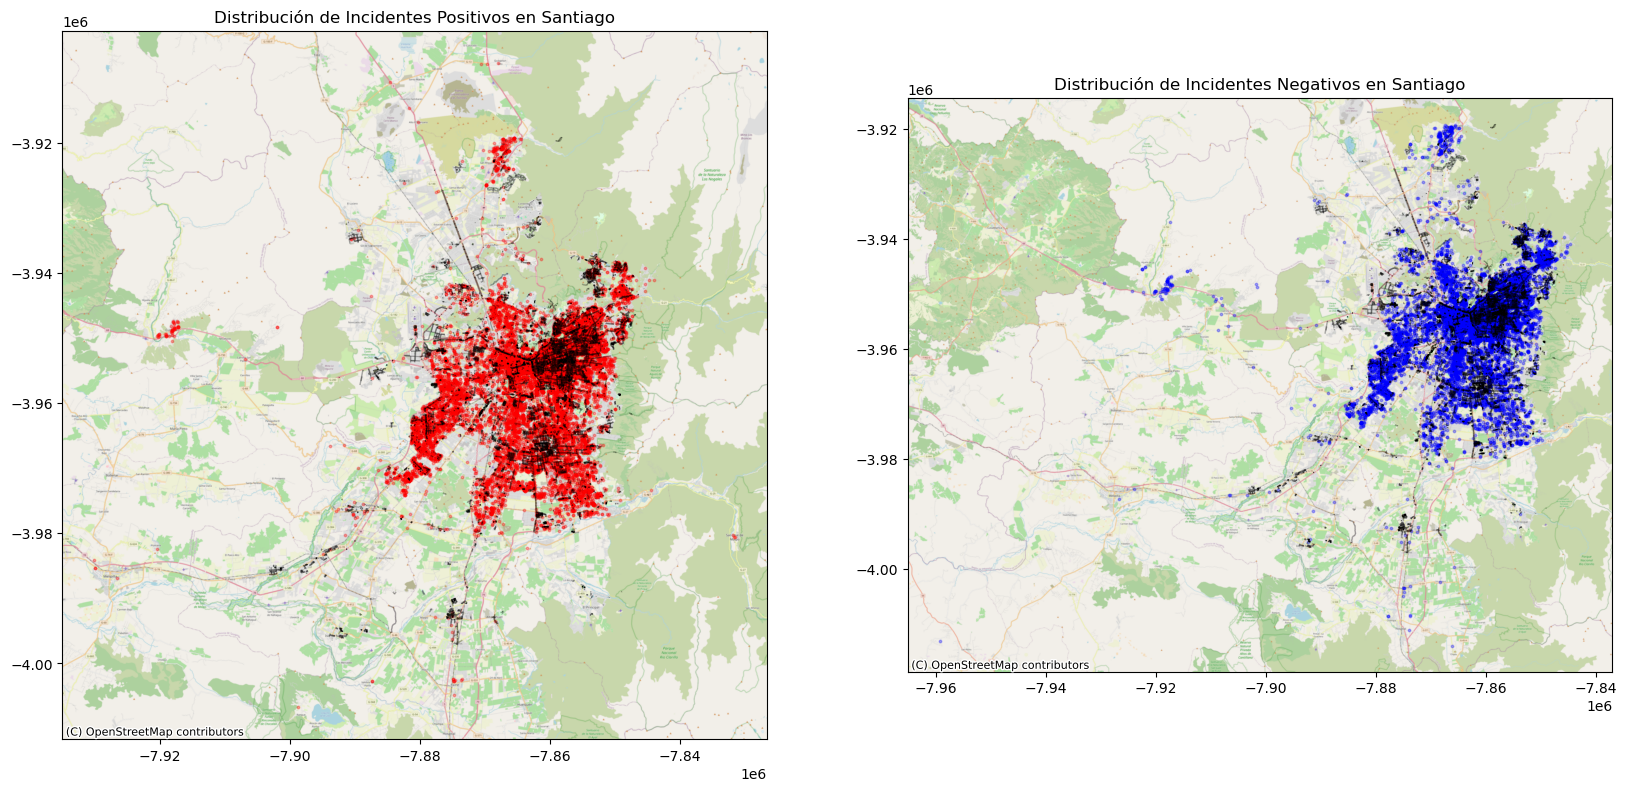

In [5]:
gdf_positive = gdf_positive.to_crs(epsg=3857)
gdf_negative = gdf_negative.to_crs(epsg=3857)

# Crear la figura y los subplots con dos columnas (2 gráficos)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Plotear los puntos del GeoDataFrame positivo en el primer subplot
gdf_positive.plot(ax=ax1, marker='o', color='red', markersize=3, alpha=0.3)
footways.plot(ax=ax1, color='black', linewidth=1, alpha=0.3)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
ax1.set_title('Distribución de Incidentes Positivos en Santiago')

# Plotear los puntos del GeoDataFrame negativo en el segundo subplot
gdf_negative.plot(ax=ax2, marker='o', color='blue', markersize=3, alpha=0.3)
footways.plot(ax=ax2, color='black', linewidth=1, alpha=0.3)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
ax2.set_title('Distribución de Incidentes Negativos en Santiago')

# Mostrar el gráfico
plt.show()

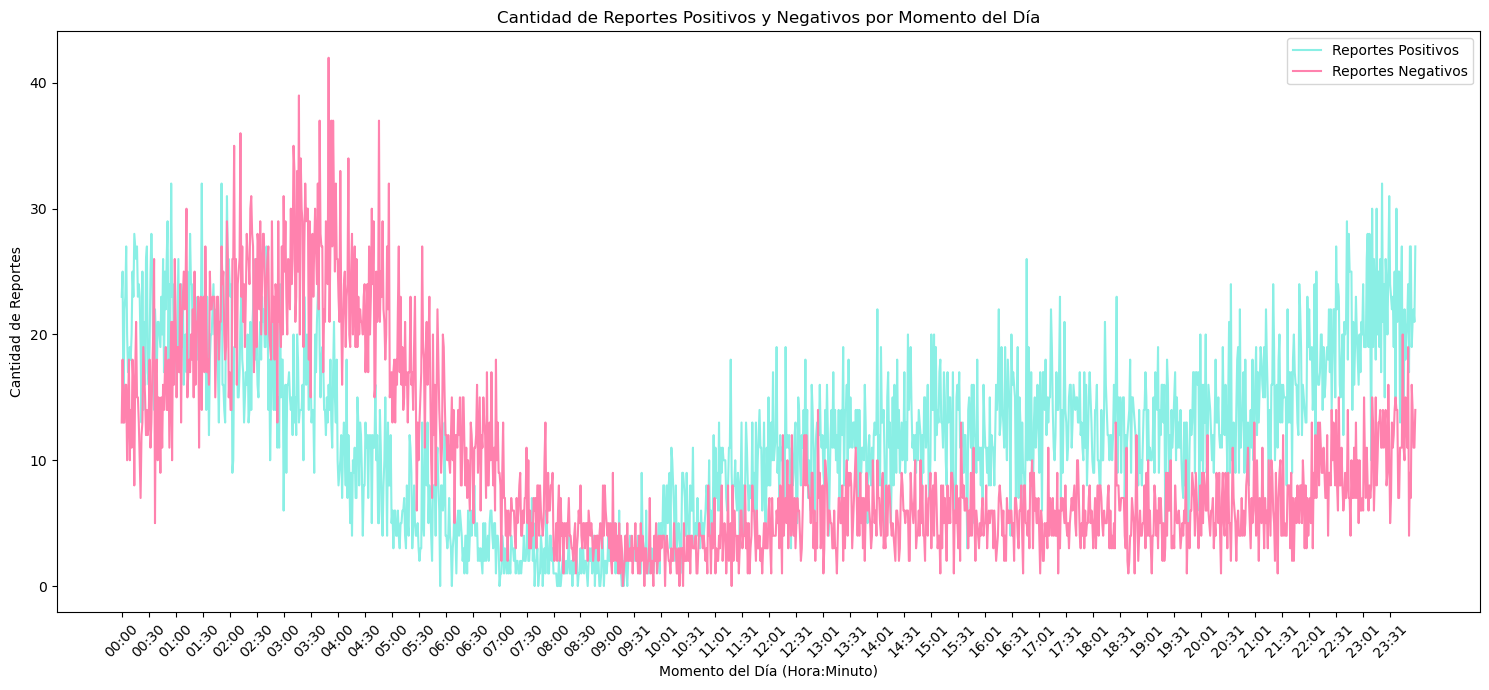

In [6]:
# Agrupamos por momento del día y contamos la cantidad de reportes
positivos_por_momento = gdf_positive['hora_exacta_del_dia'].value_counts().sort_index()
negativos_por_momento = gdf_negative['hora_exacta_del_dia'].value_counts().sort_index()

# Creamos un DataFrame combinado para asegurarnos de que las etiquetas coincidan y no falten valores
df_reportes = pd.DataFrame({
    'Positivos': positivos_por_momento,
    'Negativos': negativos_por_momento
}).fillna(0)

# Graficamos los datos temporales
plt.figure(figsize=(15, 7))

plt.plot(df_reportes.index, df_reportes['Positivos'], label='Reportes Positivos', color= '#8aefe5')
plt.plot(df_reportes.index, df_reportes['Negativos'], label='Reportes Negativos', color= '#ff82ae')

plt.xlabel('Momento del Día (Hora:Minuto)')
plt.ylabel('Cantidad de Reportes')
plt.title('Cantidad de Reportes Positivos y Negativos por Momento del Día')

# Para reducir la cantidad de etiquetas del eje x, seleccionamos cada 15 minutos
plt.xticks(ticks=range(0, len(df_reportes.index), 30), labels=df_reportes.index[::30], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

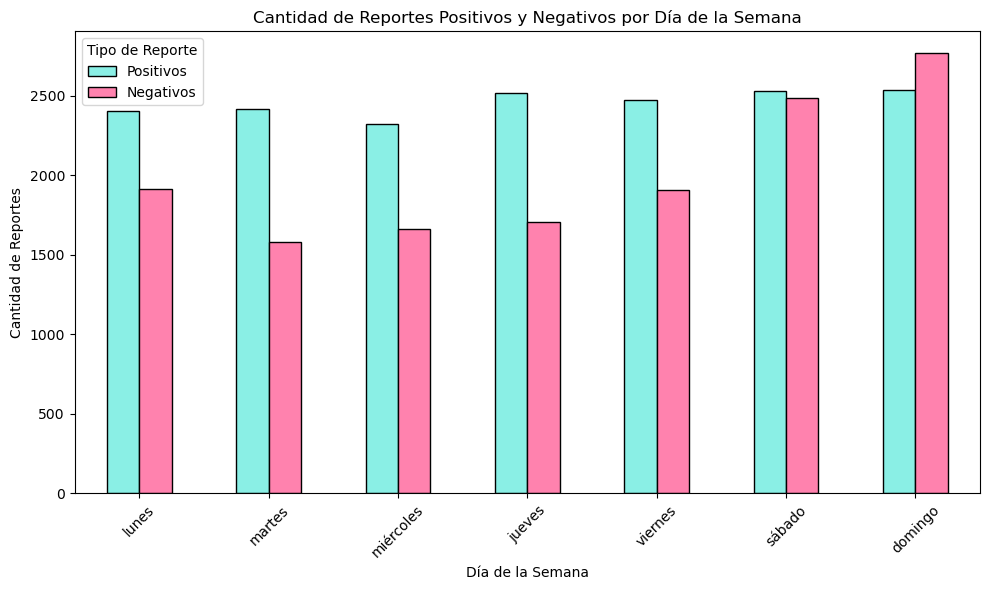

In [7]:
# Agrupamos los reportes por día de la semana y contamos la cantidad de reportes para cada uno
positivos_por_dia = gdf_positive['dia_semana'].value_counts().reindex(['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo'])
negativos_por_dia = gdf_negative['dia_semana'].value_counts().reindex(['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo'])

# Creamos un DataFrame combinado para asegurarnos de que los días coincidan
df_reportes_por_dia = pd.DataFrame({
    'Positivos': positivos_por_dia,
    'Negativos': negativos_por_dia
}).fillna(0)

# Graficamos los datos agrupados por día de la semana
plt.figure(figsize=(10, 6))

# Graficamos barras para reportes positivos y negativos
df_reportes_por_dia.plot(kind='bar', ax=plt.gca(), color=['#8aefe5','#ff82ae'], edgecolor='black')

plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Reportes')
plt.title('Cantidad de Reportes Positivos y Negativos por Día de la Semana')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Tipo de Reporte')
plt.show()

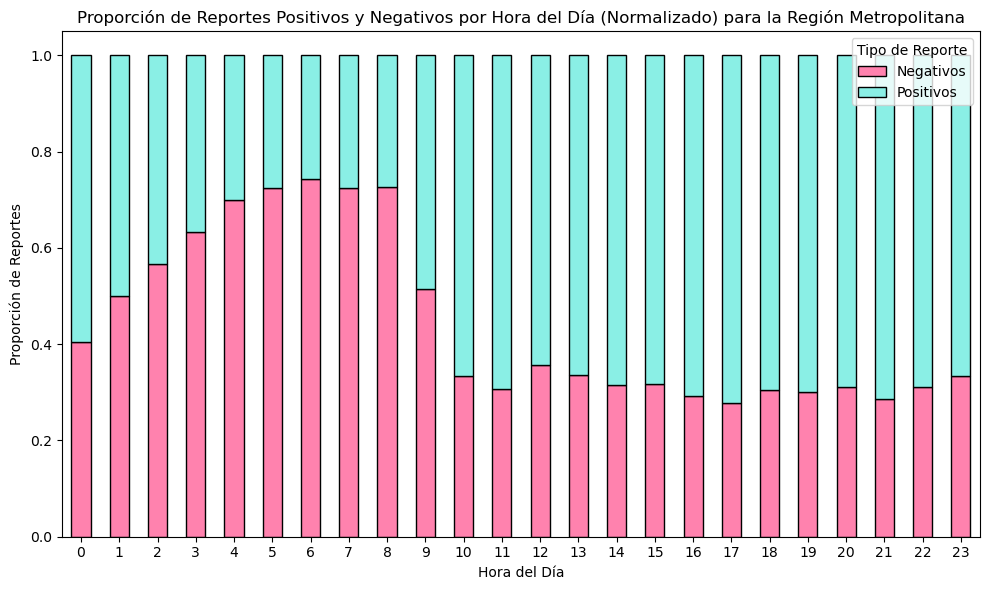

In [8]:
# Agrupamos los reportes positivos y negativos por hora del día y contamos la cantidad de reportes
positivos_por_hora = gdf_positive['hora'].value_counts().sort_index()
negativos_por_hora = gdf_negative['hora'].value_counts().sort_index()

# Creamos un DataFrame combinado para asegurar que todos los índices estén completos (0-23 horas)
df_reportes_por_hora = pd.DataFrame({
    'Negativos': negativos_por_hora,
    'Positivos': positivos_por_hora,
}).fillna(0)

# Normalizamos los valores para que la suma de Positivos y Negativos por cada hora sea 1
df_reportes_por_hora_normalizado = df_reportes_por_hora.div(df_reportes_por_hora.sum(axis=1), axis=0)

# Graficamos los datos en un gráfico de barras apiladas y normalizadas
plt.figure(figsize=(10, 6))

# Graficamos el gráfico de barras apiladas normalizado
df_reportes_por_hora_normalizado.plot(kind='bar', stacked=True, color=['#ff82ae', '#8aefe5'], edgecolor='black', ax=plt.gca())

plt.xlabel('Hora del Día')
plt.ylabel('Proporción de Reportes')
plt.title('Proporción de Reportes Positivos y Negativos por Hora del Día (Normalizado) para la Región Metropolitana')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Reporte', labels=['Negativos', 'Positivos'])
plt.tight_layout()
plt.show()

### Report_counts : 
gdf con el total de reportes por comuna, positivos, negativos y la suma y mas adelante se guarda la normalización

In [9]:
# Contar los reportes positivos y negativos por comuna
positive_counts = gdf_positive.groupby('Comuna').size().reset_index(name='Positivos')
negative_counts = gdf_negative.groupby('Comuna').size().reset_index(name='Negativos')

# Combinar los conteos en un solo DataFrame
report_counts = pd.merge(positive_counts, negative_counts, on='Comuna', how='outer').fillna(0)

# Calcular el total de reportes por comuna
report_counts['Total'] = report_counts['Positivos'] + report_counts['Negativos']

# Ordenar las comunas por la cantidad total de reportes
report_counts = report_counts.sort_values(by='Total', ascending=False)
# Restablecer los índices para que sean consecutivos
report_counts.reset_index(drop=True, inplace=True)



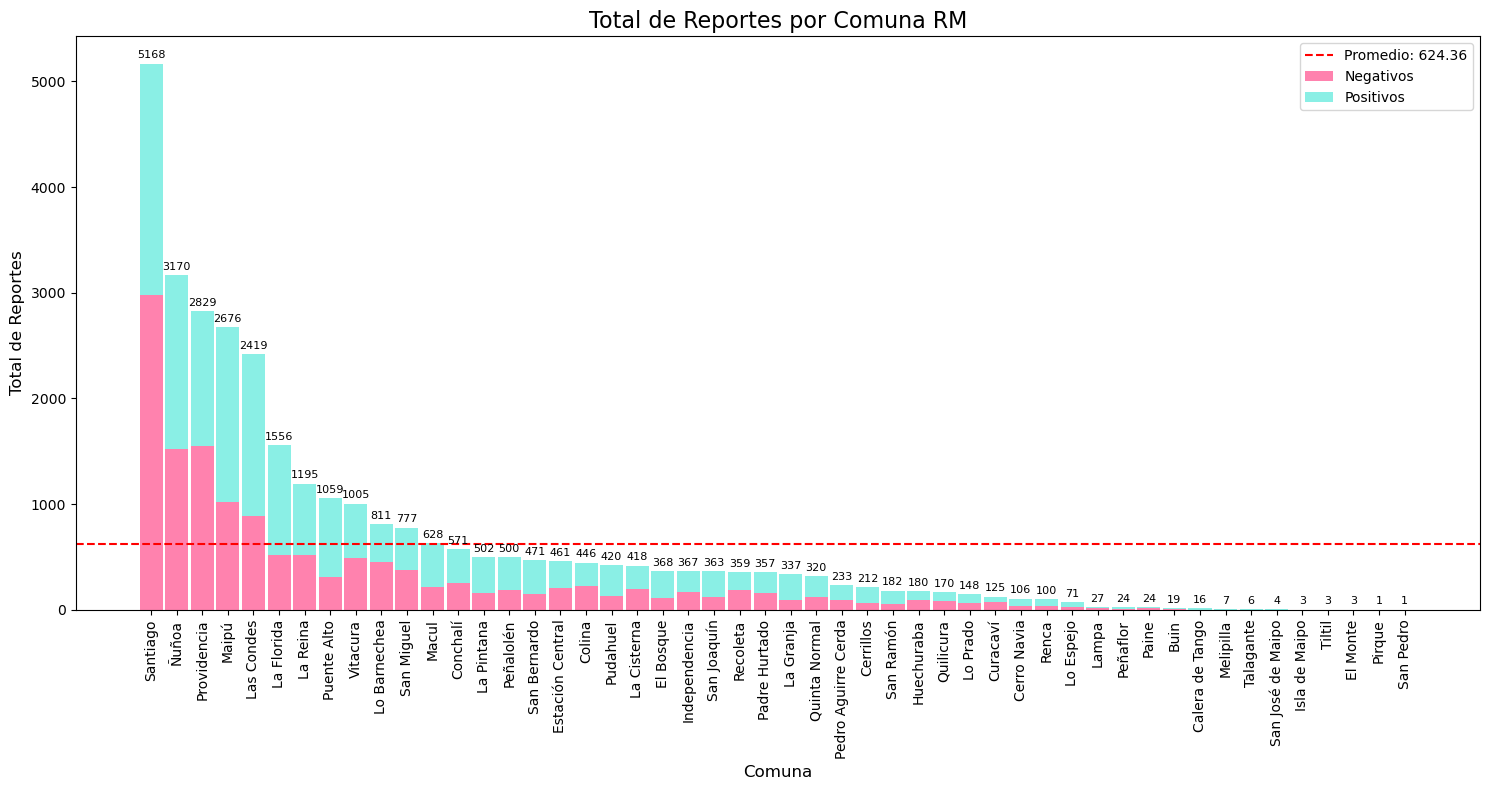

In [10]:
# Crear el gráfico de barras apiladas
plt.figure(figsize=(15, 8))
bar_width = 0.9  # Ajustar el ancho de las barras
plt.bar(report_counts['Comuna'], report_counts['Negativos'], color='#ff82ae', label='Negativos', width=bar_width)
plt.bar(report_counts['Comuna'], report_counts['Positivos'], bottom=report_counts['Negativos'], color='#8aefe5', label='Positivos', width=bar_width)

# Añadir una línea horizontal con el promedio de reportes
average = report_counts['Total'].mean()
plt.axhline(y=average, color='red', linestyle='--', label=f'Promedio: {average:.2f}')

# Añadir etiquetas de texto con la cantidad total sobre las barras
for i, total in enumerate(report_counts['Total']):
    plt.text(i, total + 50, str(int(total)), ha='center', fontsize=8)

# Personalizar el gráfico
plt.title('Total de Reportes por Comuna RM', fontsize=16)
plt.xlabel('Comuna', fontsize=12)
plt.ylabel('Total de Reportes', fontsize=12)
plt.legend()
plt.xticks(rotation=90)  # Rotar etiquetas de comunas para mejor legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


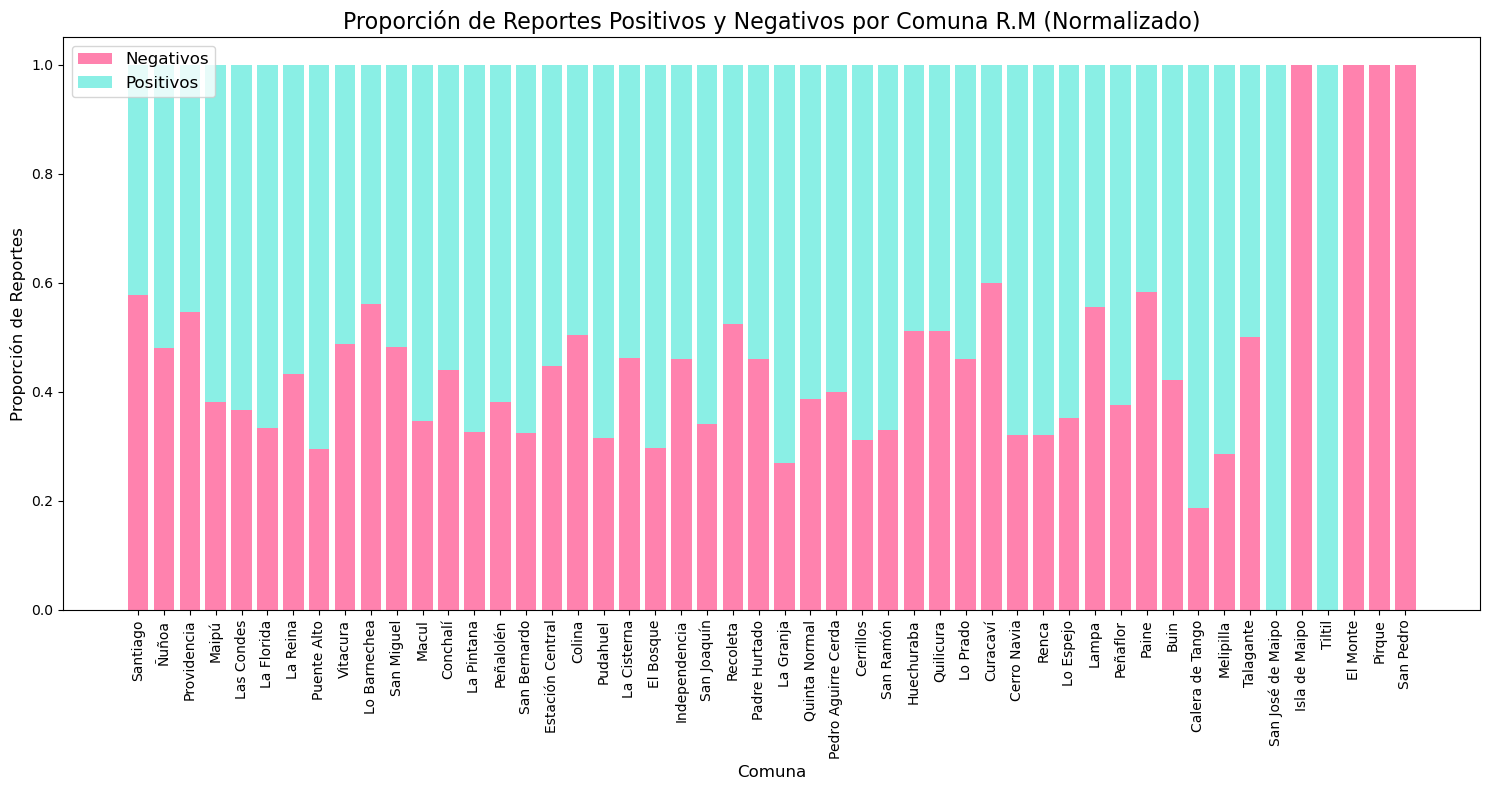

In [11]:
# Calcular las proporciones
report_counts['Positivos (%)'] = report_counts['Positivos'] / report_counts['Total']
report_counts['Negativos (%)'] = report_counts['Negativos'] / report_counts['Total']

# Crear el gráfico de barras apiladas normalizado
plt.figure(figsize=(15, 8))
plt.bar(report_counts['Comuna'], report_counts['Negativos (%)'], color= '#ff82ae', label='Negativos')
plt.bar(report_counts['Comuna'], report_counts['Positivos (%)'], bottom=report_counts['Negativos (%)'], color= '#8aefe5', label='Positivos')

# Personalizar el gráfico
plt.title('Proporción de Reportes Positivos y Negativos por Comuna R.M (Normalizado)', fontsize=16)
plt.xlabel('Comuna', fontsize=12)
plt.ylabel('Proporción de Reportes', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotar las etiquetas para mayor claridad
plt.legend(fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


/tmp/ipykernel_39705/727945055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_12['Positivos (%)'] = top_12['Positivos'] / top_12['Total']
/tmp/ipykernel_39705/727945055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_12['Negativos (%)'] = top_12['Negativos'] / top_12['Total']


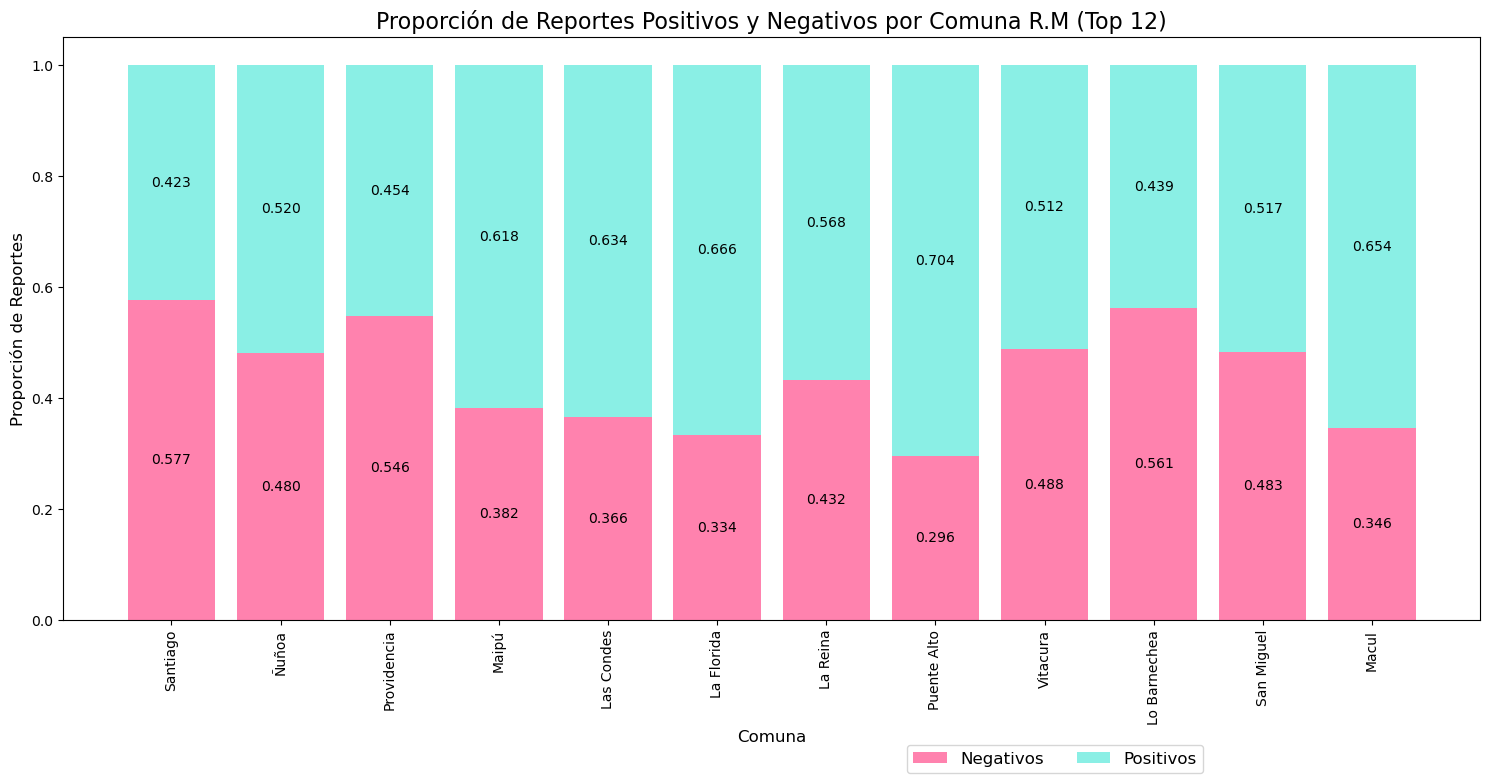

In [12]:
# Seleccionar las primeras 12 comunas
top_12 = report_counts.head(12)

# Calcular las proporciones
top_12['Positivos (%)'] = top_12['Positivos'] / top_12['Total']
top_12['Negativos (%)'] = top_12['Negativos'] / top_12['Total']

# Crear el gráfico de barras apiladas normalizado
plt.figure(figsize=(15, 8))
bars_neg = plt.bar(top_12['Comuna'], top_12['Negativos (%)'], color='#ff82ae', label='Negativos')
bars_pos = plt.bar(top_12['Comuna'], top_12['Positivos (%)'], bottom=top_12['Negativos (%)'], color='#8aefe5', label='Positivos')

# Añadir las proporciones como texto dentro de las barras
for bar, pct in zip(bars_neg, top_12['Negativos (%)']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{pct:.3f}', ha='center', va='center', fontsize=10)
for bar, pct, height in zip(bars_pos, top_12['Positivos (%)'], top_12['Negativos (%)']):
    plt.text(bar.get_x() + bar.get_width() / 2, height + bar.get_height() / 2, f'{pct:.3f}', ha='center', va='center', fontsize=10)

# Personalizar el gráfico
plt.title('Proporción de Reportes Positivos y Negativos por Comuna R.M (Top 12)', fontsize=16)
plt.xlabel('Comuna', fontsize=12)
plt.ylabel('Proporción de Reportes', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotar etiquetas para mejor visibilidad
plt.legend(loc='upper center', bbox_to_anchor=(0.7, -0.2), ncol=2, fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Nube

In [13]:
positive_words = [
    "buen estado", "bien iluminado", "luz suficiente", "zona iluminada", "árbol", "jardín", "área verde",
    "paisaje", "sombras", "parque", "plaza", "banco", "agradable", "bonito", "hermoso", "pintoresco",
    "zona segura", "calle tranquila", "camino favorito", "paseo relajante", "camino que disfruto",
    "agradable para caminar", "cerca del metro", "acceso a buses", "estación de metro", "paradero",
    "soleado", "sombras", "calor", "viento", "lindo"
]

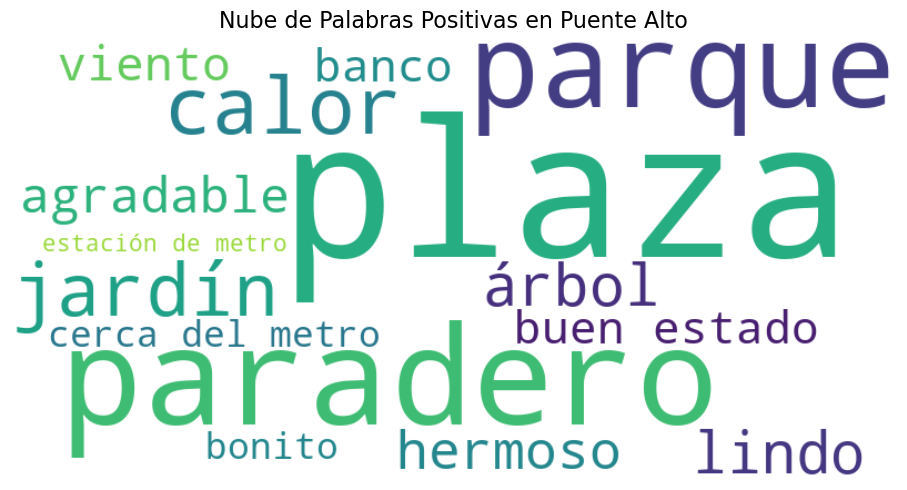

In [14]:
puente_alto_data = gdf_positive[gdf_positive['Comuna'] == 'Puente Alto']

# Unir todos los textos en un solo string
all_text = " ".join(puente_alto_data['description'].astype(str))

# Filtrar las palabras de interés de la lista positive_words
word_frequencies = {word: all_text.lower().count(word) for word in positive_words}

# Crear la nube de palabras
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate_from_frequencies(word_frequencies)

# Mostrar el gráfico
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.title('Nube de Palabras Positivas en Puente Alto', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
negative_words = [
    "bache", "hueco", "asfalto roto", "pavimento en mal estado", "fisura", "grieta", "acera rota",
    "vereda en mal estado", "baldosas levantadas", "escombros en la acera", "falta de mantención",
    "desnivel", "escombros", "calle en mal estado", "falta de pavimento", "obstáculo", "construcción",
    "tuberías rotas", "materiales en la vía", "barrera en la calle", "falta de rampa", "escalón",
    "inaccesible", "no apto para sillas de ruedas", "dificultad para cruzar", "persona con movilidad reducida",
    "falta de iluminación", "luz rota", "faroles apagados", "calle oscura", "zona sin luz", "ruido",
    "contaminación sonora", "molestias por ruido", "zona ruidosa", "contaminación", "mal olor", "zona fea",
    "lugar sucio", "peligroso", "zona insegura", "asaltos", "robos", "vandalismo", "peligro", "resbaladizo",
    "inseguro", "zona en mal estado", "riesgo de accidente", "evitar esta ruta", "me siento incómodo",
    "no me gusta esta calle", "mucho tráfico", "congestión vehicular", "calle con autos", "ruido de autos"
]

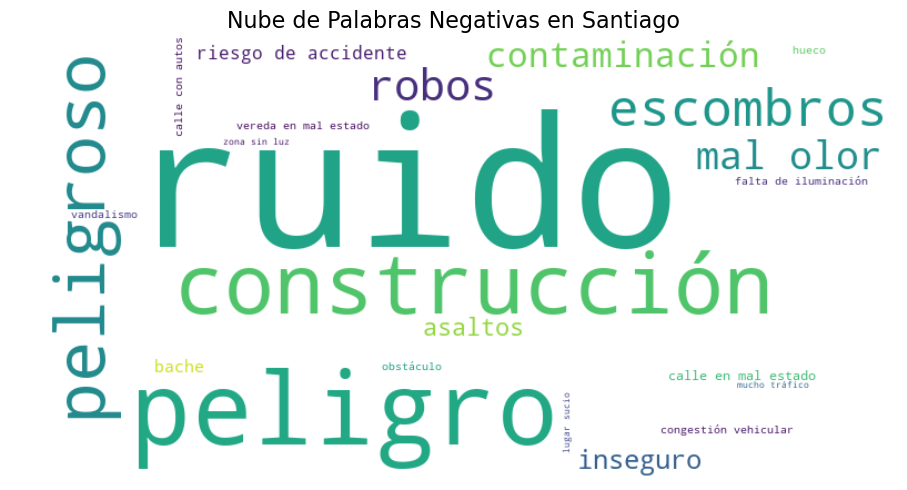

In [16]:
# Filtrar los datos para la comuna de Santiago
santiago_data = gdf_negative[gdf_negative['Comuna'] == 'Santiago']

# Unir todos los textos en un solo string
all_text = " ".join(santiago_data['description'].astype(str))

# Filtrar las palabras de interés de la lista negative_words
word_frequencies = {word: all_text.lower().count(word) for word in negative_words}

# Crear la nube de palabras
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate_from_frequencies(word_frequencies)

# Mostrar el gráfico
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.title('Nube de Palabras Negativas en Santiago', fontsize=16)
plt.tight_layout()
plt.show()